# Pipeline Melhorado de Processamento Digital de Imagem
Sistema otimizado com segmentação por Flood Fill e extração avançada de características para reconhecimento de produtos.


In [73]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.feature import local_binary_pattern, hog, graycomatrix, graycoprops


In [ ]:
def converter_para_cinza(imagem):
    """Converte imagem colorida para escala de cinza."""
    return cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

def aplicar_filtro_gaussiano(imagem, tamanho_kernel=(5, 5)):
    """Aplica filtro de suavização gaussiana."""
    return cv2.GaussianBlur(imagem, tamanho_kernel, 0)

def detectar_bordas_canny(imagem, limiar_baixo=100, limiar_alto=200):
    """Detecta bordas usando algoritmo de Canny."""
    return cv2.Canny(imagem, limiar_baixo, limiar_alto)

def encontrar_contornos(mascara_binaria):
    """Encontra contornos em uma máscara binária."""
    contornos, _ = cv2.findContours(mascara_binaria.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contornos

def desenhar_contornos(imagem, contornos, cor=(0, 255, 0), espessura=2):
    """Desenha contornos sobre uma imagem."""
    imagem_contornos = imagem.copy()
    cv2.drawContours(imagem_contornos, contornos, -1, cor, espessura)
    return imagem_contornos

def extrair_caracteristicas_forma(contornos):
    """Extrai características geométricas dos contornos."""
    caracteristicas = []
    for contorno in contornos:
        area = cv2.contourArea(contorno)
        perimetro = cv2.arcLength(contorno, True)
        x, y, w, h = cv2.boundingRect(contorno)
        circularidade = 4 * np.pi * area / (perimetro ** 2) if perimetro > 0 else 0.0
        
        caracteristicas.append({
            "area": float(area),
            "perimetro": float(perimetro),
            "bounding_box": (int(x), int(y), int(w), int(h)),
            "circularidade": float(circularidade),
        })
    return caracteristicas

def extrair_lbp(imagem, P=8, R=1):
    """Extrai características LBP (Local Binary Pattern)."""
    lbp = local_binary_pattern(imagem, P=P, R=R, method="uniform")
    lbp_norm = (lbp - lbp.min()) / (lbp.max() - lbp.min() + 1e-9)
    lbp_img = (lbp_norm * 255).astype("uint8")
    
    # Histograma
    lbp_bins = np.arange(0, lbp.max() + 2)
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=lbp_bins, density=True)
    
    return lbp_img, lbp_hist

def extrair_glcm(imagem, distancias=[1, 2, 3], angulos=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    """Extrai características GLCM (Gray-Level Co-occurrence Matrix)."""
    glcm = graycomatrix(imagem, distances=distancias, angles=angulos, levels=256, symmetric=True, normed=True)
    
    caracteristicas = {}
    propriedades = ["contrast", "dissimilarity", "homogeneity", "ASM", "energy", "correlation"]
    
    for prop in propriedades:
        caracteristicas[prop] = float(graycoprops(glcm, prop).mean())
    
    return caracteristicas

def extrair_hog(imagem, orientacoes=9, pixels_por_celula=(16, 16), celulas_por_bloco=(2, 2)):
    """Extrai características HOG (Histogram of Oriented Gradients)."""
    hog_vector, hog_vis = hog(
        imagem,
        orientations=orientacoes,
        pixels_per_cell=pixels_por_celula,
        cells_per_block=celulas_por_bloco,
        visualize=True,
        block_norm="L2-Hys",
        feature_vector=True,
    )
    
    # Normalizar para visualização
    hog_vis_norm = (hog_vis - hog_vis.min()) / (hog_vis.max() - hog_vis.min() + 1e-9)
    hog_img = (hog_vis_norm * 255).astype("uint8")
    
    return hog_vector, hog_img


def segmentar_objeto_com_flood_fill(imagem):
    """
    Segmenta objeto principal removendo fundos conectados às bordas.
    Ideal para objetos com fundo branco.
    """
    # 1. Limiarização Otsu INVERTIDA (objeto = 255, fundo = 0)
    _, mascara = cv2.threshold(imagem, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # 2. Remover regiões conectadas às bordas (fundo)
    h, w = mascara.shape
    ff = mascara.copy()
    ff_mask = np.zeros((h + 2, w + 2), np.uint8)  # máscara do floodFill precisa ser 2px maior
    
    # Flood fill nos 4 cantos (bordas)
    for seed in [(0, 0), (w - 1, 0), (0, h - 1), (w - 1, h - 1)]:
        cv2.floodFill(ff, ff_mask, seedPoint=seed, newVal=0)
    
    # 3. Limpeza morfológica
    kernel = np.ones((3, 3), np.uint8)
    ff = cv2.morphologyEx(ff, cv2.MORPH_OPEN, kernel, iterations=1)
    ff = cv2.morphologyEx(ff, cv2.MORPH_CLOSE, kernel, iterations=1)
    
    return ff

def filtrar_contornos_borda(contornos, largura_imagem, altura_imagem, margem=1):
    """
    Remove contornos que tocam a borda da imagem.
    """
    def toca_borda(x, y, w, h, W, H, m=1):
        return x <= m or y <= m or (x + w) >= (W - m) or (y + h) >= (H - m)
    
    contornos_filtrados = []
    for contorno in contornos:
        x, y, w, h = cv2.boundingRect(contorno)
        if not toca_borda(x, y, w, h, largura_imagem, altura_imagem, margem):
            contornos_filtrados.append(contorno)
    
    return contornos_filtrados


In [85]:
def processar_imagem(caminho_imagem, pasta_saida="processed"):
    """
    Pipeline melhorado com segmentação por flood fill para reconhecimento de produtos.
    
    Características principais:
    - Segmentação precisa com Flood Fill
    - Filtro de contornos que tocam bordas
    - Extração avançada de características (LBP, GLCM, HOG)
    - Limpeza morfológica para remover ruído
    """
    
    caminho_imagem = Path(caminho_imagem)
    pasta_saida = Path(pasta_saida)
    
    if not caminho_imagem.exists():
        raise FileNotFoundError(f"Imagem {caminho_imagem} não encontrada.")
    
    imagem_original = cv2.imread(str(caminho_imagem))
    if imagem_original is None:
        raise ValueError(f"Falha ao ler a imagem {caminho_imagem} com o OpenCV.")
    
    nome_imagem = caminho_imagem.stem
    pasta_saida.mkdir(parents=True, exist_ok=True)
    
    cv2.imwrite(str(pasta_saida / f"{nome_imagem}_original.png"), imagem_original)
    
    # 1. Pré-processamento
    cinza = converter_para_cinza(imagem_original)
    gaussiano = aplicar_filtro_gaussiano(cinza)
    
    cv2.imwrite(str(pasta_saida / f"{nome_imagem}_cinza.png"), cinza)
    cv2.imwrite(str(pasta_saida / f"{nome_imagem}_gaussiano.png"), gaussiano)
    
    # 2. Segmentação melhorada com Flood Fill
    mascara_limpa = segmentar_objeto_com_flood_fill(gaussiano)
    bordas = detectar_bordas_canny(gaussiano)
    
    # 3. Contornos filtrados
    contornos_todos = encontrar_contornos(mascara_limpa)
    contornos_filtrados = filtrar_contornos_borda(contornos_todos, gaussiano.shape[1], gaussiano.shape[0])
    imagem_contornos = desenhar_contornos(imagem_original, contornos_filtrados)
    
    # Salvar resultados de segmentação
    cv2.imwrite(str(pasta_saida / f"{nome_imagem}_mascara_limpa.png"), mascara_limpa)
    cv2.imwrite(str(pasta_saida / f"{nome_imagem}_bordas.png"), bordas)
    cv2.imwrite(str(pasta_saida / f"{nome_imagem}_contornos.png"), imagem_contornos)
    
    # 4. Extração de características avançadas
    caracteristicas_forma = extrair_caracteristicas_forma(contornos_filtrados)
    lbp_img, lbp_hist = extrair_lbp(cinza)
    glcm_caracteristicas = extrair_glcm(cinza)
    hog_vector, hog_img = extrair_hog(cinza)
    
    resultados = processar_imagem("apple.jpg", "processed")

    # Salvar características visuais
    cv2.imwrite(str(pasta_saida / f"{nome_imagem}_lbp.png"), lbp_img)
    cv2.imwrite(str(pasta_saida / f"{nome_imagem}_hog.png"), hog_img)
    
    # Retornar resultados completos
    return {
        "imagem_original": imagem_original,
        "cinza": cinza,
        "gaussiano": gaussiano,
        "mascara_limpa": mascara_limpa,
        "bordas": bordas,
        "contornos_todos": contornos_todos,
        "contornos_filtrados": contornos_filtrados,
        "imagem_contornos": imagem_contornos,
        "caracteristicas_forma": caracteristicas_forma,
        "lbp_histograma": lbp_hist,
        "glcm_caracteristicas": glcm_caracteristicas,
        "hog_vector": hog_vector,
        "hog_imagem": hog_img
    }


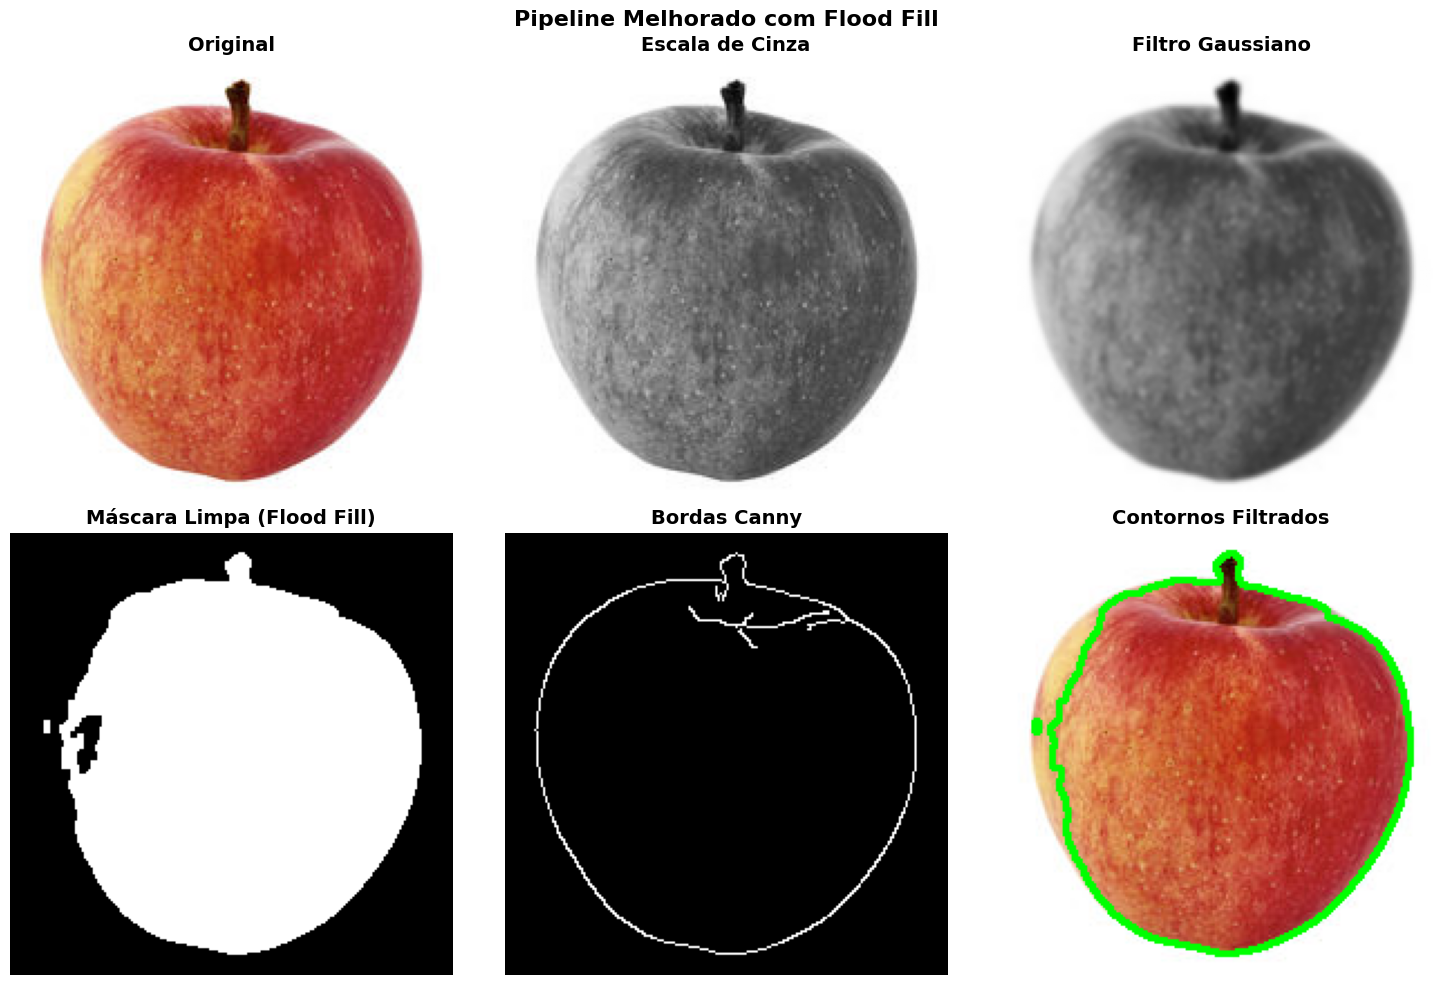

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Primeira linha - Pré-processamento
axes[0, 0].imshow(cv2.cvtColor(resultados['imagem_original'], cv2.COLOR_BGR2RGB))
axes[0, 0].set_title("Original", fontsize=14, fontweight='bold')
axes[0, 0].axis("off")

axes[0, 1].imshow(resultados['cinza'], cmap="gray")
axes[0, 1].set_title("Escala de Cinza", fontsize=14, fontweight='bold')
axes[0, 1].axis("off")

axes[0, 2].imshow(resultados['gaussiano'], cmap="gray")
axes[0, 2].set_title("Filtro Gaussiano", fontsize=14, fontweight='bold')
axes[0, 2].axis("off")

# Segunda linha - Segmentação melhorada
axes[1, 0].imshow(resultados['mascara_limpa'], cmap="gray")
axes[1, 0].set_title("Máscara Limpa (Flood Fill)", fontsize=14, fontweight='bold')
axes[1, 0].axis("off")

axes[1, 1].imshow(resultados['bordas'], cmap="gray")
axes[1, 1].set_title("Bordas Canny", fontsize=14, fontweight='bold')
axes[1, 1].axis("off")

axes[1, 2].imshow(cv2.cvtColor(resultados['imagem_contornos'], cv2.COLOR_BGR2RGB))
axes[1, 2].set_title("Contornos Filtrados", fontsize=14, fontweight='bold')
axes[1, 2].axis("off")

plt.suptitle("Pipeline Melhorado com Flood Fill", fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()


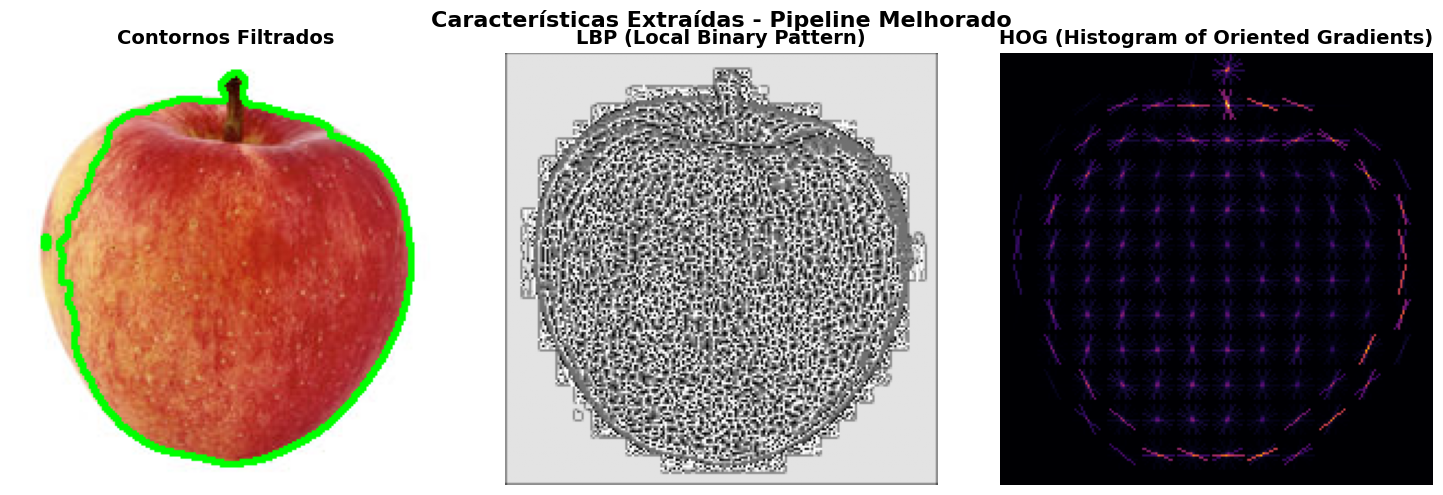

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Contornos filtrados
axes[0].imshow(cv2.cvtColor(resultados['imagem_contornos'], cv2.COLOR_BGR2RGB))
axes[0].set_title("Contornos Filtrados", fontsize=14, fontweight='bold')
axes[0].axis("off")

# LBP - Mostrar a imagem LBP
lbp_img, _ = extrair_lbp(resultados['cinza'])
axes[1].imshow(lbp_img, cmap="gray")
axes[1].set_title("LBP (Local Binary Pattern)", fontsize=14, fontweight='bold')
axes[1].axis("off")

# HOG
axes[2].imshow(resultados['hog_imagem'], cmap="inferno")
axes[2].set_title("HOG (Histogram of Oriented Gradients)", fontsize=14, fontweight='bold')
axes[2].axis("off")

plt.suptitle("Características Extraídas - Pipeline Melhorado", fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()
